### Squad Azul: Camila, Juliana e Phillip

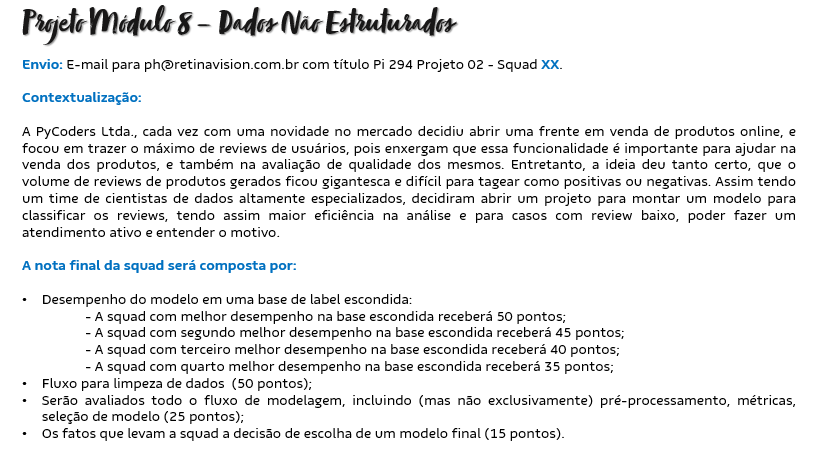

In [1]:
from IPython.core.display import Image, display
display(Image(filename='descript_projeto_m8.png'))

In [2]:
#bibliotecas usuais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#bibliotecas para tratamento de dados, criação do modelo e avaliação deste
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression

#biblioteca para NLP
import spacy

#não imprimir os avisos/recomendações
import warnings
warnings.filterwarnings("ignore")

#pickle para salvar o modelo
import pickle

### Pré-avaliação da base de dados

In [3]:
df = pd.read_csv('pycoders_reviews.tsv', sep = '\t')

In [4]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [5]:
#input da base de dados - large
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [6]:
df.shape

(9200, 2)

In [7]:
df['label'].value_counts()

neg    4691
pos    4509
Name: label, dtype: int64

In [8]:
print('neg:', round((4691*100)/9200,2))
print('pos:', round((4509*100)/9200,2))

neg: 50.99
pos: 49.01


#### Portanto as classes não estão desbalanceadas. 

### Limpeza/Tratamento de dados: Transformação em binário, remoção de stop words e Lematizar

In [9]:
#função para tornar base binária para modelo de classificação
def transforma_label (valor):
    if valor == 'pos':
        return 1
    elif valor == 'neg':
        return 0
    else:
        return 2

In [10]:
df_sent = df.copy()

In [11]:
df_sent['label'] = df_sent['label'].apply(transforma_label)
#checando
df_sent.label.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

#### Verificando e fazendo as transformações na parte textual:

- identificar e remover stopwords
- lematizar

In [12]:
df_sent['review']

0       Stuning even for the non-gamer: This sound tra...
1       The best soundtrack ever to anything.: I'm rea...
2       Amazing!: This soundtrack is my favorite music...
3       Excellent Soundtrack: I truly like this soundt...
4       Remember, Pull Your Jaw Off The Floor After He...
                              ...                        
9195    A revelation of life in small town America in ...
9196    Great biography of a very interesting journali...
9197    Interesting Subject; Poor Presentation: You'd ...
9198    Don't buy: The box looked used and it is obvio...
9199    Beautiful Pen and Fast Delivery.: The pen was ...
Name: review, Length: 9200, dtype: object

In [13]:
nlp = spacy.load('en_core_web_lg')

In [17]:
#função geral com outras funções parciais dentro - a ser carregada em outro código/arquivo
def aplica_transformacoes (string):
    
    def rmv_stopwords (string):
    
        doc = nlp(string)
        doc_sem_stop_words = [token.orth_ for token in doc if not token.is_stop]
        
        return " ".join(doc_sem_stop_words)

    def lematiza (string):

        doc = nlp(string)
        lemma = [token.lemma_ for token in doc]

        return " ".join(lemma)
    
    string = rmv_stopwords(string)
    string = lematiza(string)

    return string

In [18]:
%%time
df_sent['review'] = df_sent['review'].apply(aplica_transformacoes)

CPU times: user 6min 20s, sys: 422 ms, total: 6min 20s
Wall time: 6min 21s


In [19]:
df_sent.head()

,label,review
0,1,stun non - gamer : sound track beautiful ! pai...
1,1,good soundtrack . : read lot review say good '...
2,1,"amazing ! : soundtrack favorite music time , h..."
3,1,excellent soundtrack : truly like soundtrack e...
4,1,"remember , pull Jaw Floor hearing : play game ..."


### Separando a base em treino e validação

In [20]:
X = df_sent['review']
y = df_sent['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Vectorizer, Modelo e Validação (métricas)

In [24]:
#aplicando vectorizer na coluna Review
vectorizer = CountVectorizer()

X_train_vetor = vectorizer.fit_transform(X_train)
X_test_vetor = vectorizer.transform(X_test)

In [26]:
%%time

#Criando modelo de predição
modelo = LogisticRegression()

modelo.fit(X_train_vetor, y_train)

y_pred_proba = modelo.predict_proba(X_test_vetor)[:,1]
y_pred = modelo.predict(X_test_vetor)

CPU times: user 2.26 s, sys: 1.62 s, total: 3.88 s
Wall time: 1.17 s


In [32]:
#Métricas de avaliação
print("-------------------------------------")
print("ROC: ", round(roc_auc_score(y_test, y_pred_proba),2))
print("-------------------------------------")
print("ACURÁCIA: ", round(accuracy_score(y_test, y_pred),2))

-------------------------------------
ROC:  0.92
-------------------------------------
ACURÁCIA:  0.84


### Salvando o Modelo

In [33]:
#função para salvar o modelo em .pkl
def save_model(modelo, fname):
    """
    Pickles model under "self.reg".
    :param fname: path/to/file where to save model
    """
    with open(fname, 'wb') as ofile:
        pickle.dump(modelo, ofile, pickle.HIGHEST_PROTOCOL)

#função para importarmos algum modelo em .pkl
def load_model(modelo, fname):
    """
    Loads model under "self.reg".
    :param fname: path/to/file where model is pickled.
    """
    with open(fname, 'rb') as ifile:
        reg = pickle.load(ifile)
        
    return reg

In [34]:
save_model(modelo,'review_pycoders')

### Considerações finais 

- Em uma base de dados com a label escondida, basta aplicarmos a função de "aplica_transformacoes" que remove as stop words e lematiza a base de dados a ser predita. 
- O modelo escolhido foi a regressão logistica por ser um modelo de reprodutibilidade rápida e facilmente explicado.
- Tanto as métricas de acurácia (taxa de acerto) e de discriminação (ROC) foram satisfatórias para considerarmos a utilização do modelo. 
- A base de dados balanceada facilitou o treinamento do modelo também. 
- O modelo é facilmente salvo e importado com as funcoes utilizando a biblioteca pickle.